In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

In [7]:
f(3.0)

20.0

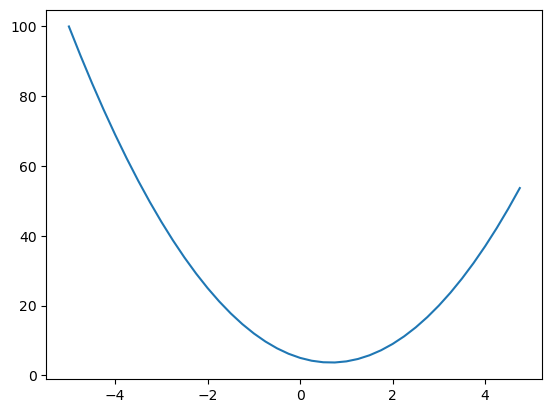

In [8]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs , ys)
plt.show()

In [9]:
h = 0.000000001
x = 3.0
(f(x+h) - f(x))/h

14.000001158365194

In [10]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a+=h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [12]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = '') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self) -> str:
        return f"Value(data = {self.data}, label = {self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad+= out.grad
            other.grad+= out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad+= other.data * out.grad
            other.grad+= self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    def __pow__(self, other):
        assert isinstance(other, (int,float))
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad = other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
        
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad+= (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad+= out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [13]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
a - b

Value(data = -2.0, label = )

In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot  


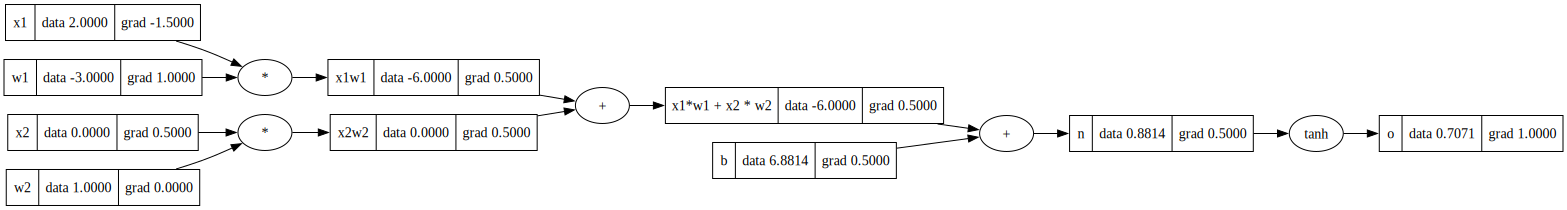

In [15]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2 * w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

o.backward()
draw_dot(o)

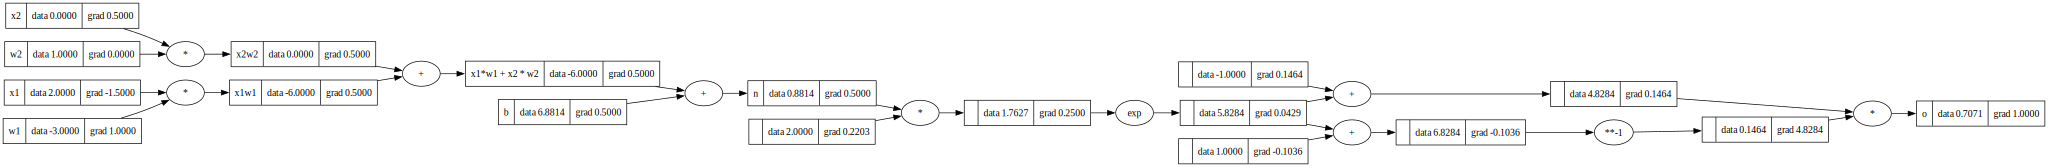

In [16]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2 * w2'
n = x1w1x2w2 + b
n.label = 'n'
# ----------
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [17]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

0.7071066904050358


In [18]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        

class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

n.parameters()

[3, 4, 4, 1]


[Value(data = 0.8033831578432138, label = ),
 Value(data = 0.3161373976782451, label = ),
 Value(data = 0.9424968477397817, label = ),
 Value(data = 0.8112598242942746, label = ),
 Value(data = -0.6097602770226465, label = ),
 Value(data = 0.7636878247578431, label = ),
 Value(data = -0.31127599397910344, label = ),
 Value(data = -0.38665017493585196, label = ),
 Value(data = 0.8356578243916786, label = ),
 Value(data = 0.9814088554131721, label = ),
 Value(data = 0.6378895179897364, label = ),
 Value(data = 0.700717101273612, label = ),
 Value(data = -0.6040853820945624, label = ),
 Value(data = -0.11592018133865434, label = ),
 Value(data = 0.3165076014859938, label = ),
 Value(data = -0.7180915006736572, label = ),
 Value(data = 0.5111352813697794, label = ),
 Value(data = 0.5027663548761689, label = ),
 Value(data = 0.3338609165834632, label = ),
 Value(data = -0.7589161552597348, label = ),
 Value(data = -0.913590340162953, label = ),
 Value(data = 0.3241868928600071, label = ),
 

In [20]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [23]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = Value(0.0)
  for ygt, yout in zip(ys, ypred):
      loss= loss + (yout - ygt)**2
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 7.59281478347749
1 7.256704337768484
2 6.08488729063529
3 2.771124903551202
4 1.856455076643464
5 2.082325065742481
6 4.044616530638985
7 0.6556973153188864
8 0.044656814496126344
9 0.039069680035432125
10 0.035075711415605206
11 0.03200184311863171
12 0.029519271531775228
13 0.027447210984778155
14 0.025676960476411916
15 0.02413837680000858
16 0.02278355032701335
17 0.021578216366783576
18 0.020496936547147702
19 0.019520242856013812
